<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Unsupervised Machine Learning - Final Assignment</font></h1>


# Introduction

The aim of this workbook is to use unsupervised learning to draw insights from a dataset.

# Dataset Info

- name :  California Housing Prices
- url : https://www.kaggle.com/datasets/camnugent/california-housing-prices

The aim of this workbook is to use KMeans, MeanShift and DBSCAN to aggregate the California Housing Prices Dataset based on a variety of pairwise factors.
We will be using the elbow method to determine the optimal k using sum of squared distances (inertia).

## Lib Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from scipy.spatial.distance import cosine, cityblock

## 1. EDA

### 1.1 Data Loading

In [3]:
housing_df = pd.read_csv('housing.csv')

In [4]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_df.isna().sum() * 100 / len(housing_df)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        1.002907
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

So there only seem to be missing entries for total_bedrooms, and the missing values account for 1.% of values, which is insignificant. I'm going to quickly review the object column ocean_property to make sure there aren't any missing values there either.

In [6]:
housing_df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

Seems fine so I will drop all missing values from the dataframe.

In [7]:
housing_df.dropna(inplace=True)
housing_df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [8]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 1.2 Data Analysis

Now I am going to have a review of the numerical features.

In [9]:
NUMERICAL_COLS = [col for col in housing_df.columns if housing_df[col].dtype != 'object']

In [10]:
housing_df[NUMERICAL_COLS].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

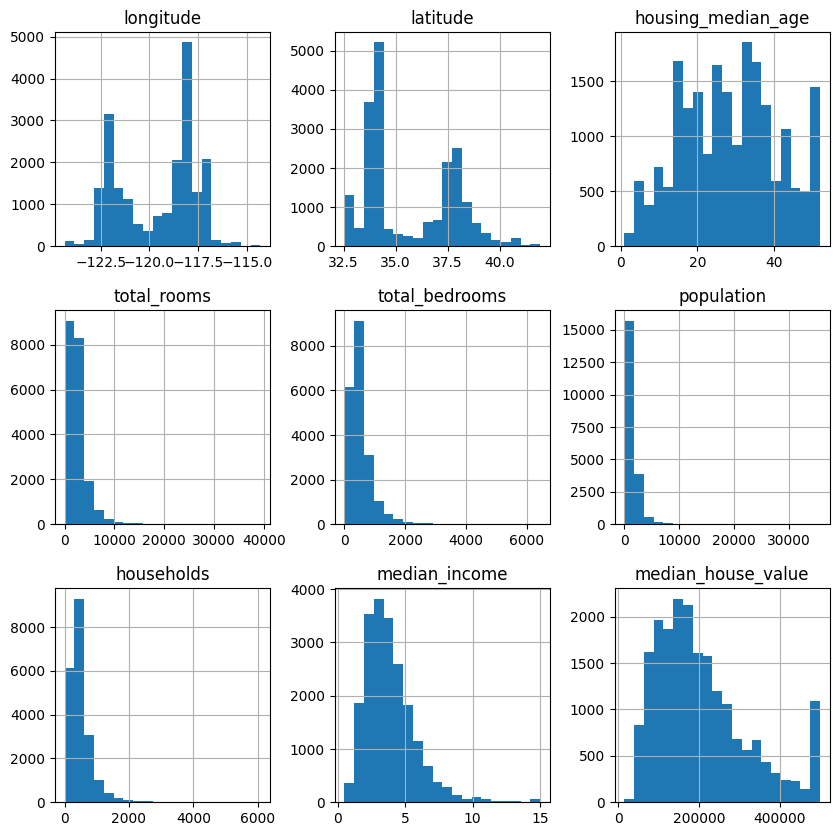

In [11]:
housing_df[NUMERICAL_COLS].hist(bins=20, figsize=(10, 10))

Alot of the numerical columns are exhibiting positive skewness, with the mode value being less than the mean. As such the dataset will have to be normalized prior to any clustering.

### 1.3 Pairwise Feature Comparison

__Latitude vs Longitude Scatter__

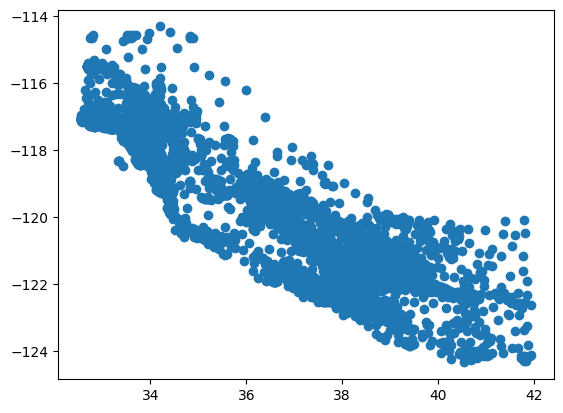

In [12]:
plt.scatter(housing_df['latitude'], housing_df['longitude'])

__Median Income vs Median House Value__

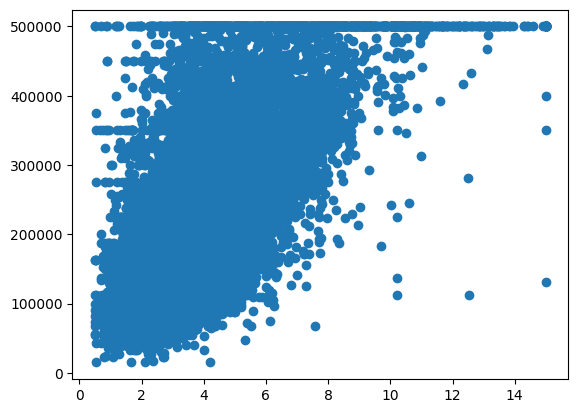

In [13]:
plt.scatter(housing_df['median_income'], housing_df['median_house_value'])

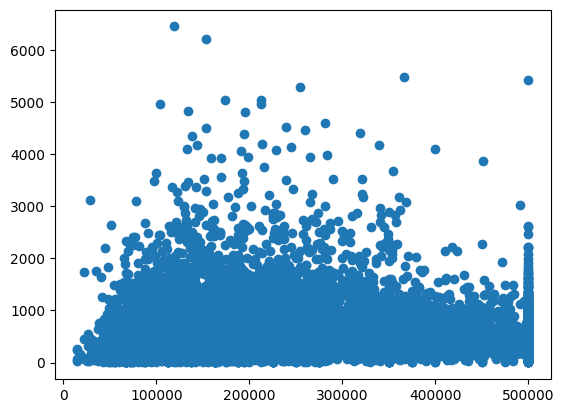

In [14]:
plt.scatter(housing_df['median_house_value'], housing_df['total_bedrooms'])

__A Note On Feature Scaling__

The k-means algorithm is sensitive to scale. Given this, the last two Clustering Pairs will need to be scaled as their values are not directly comparable.

## 3. Clustering

Now I am going to using KMeans, DBSCAN and Mean Shift to cluster the dataset according to latitude and longitude.

__Clustering Helpers__

In [42]:
def plot_kmeans_elbow(X, cluster_cols):
    """_summary_

    Args:
        X (_type_): _description_
        cluster_cols (_type_): _description_
    """
    assert(len(cluster_cols) == 2)
    n_clusters = list(range(1, 15))
    inertias = []

    for cluster in n_clusters:
        k_means = KMeans(n_clusters=cluster)
        k_means.fit(X)
        inertias.append(k_means.inertia_)

    fig, ax = plt.subplots()
    ax.plot(n_clusters, inertias, marker='x')
    ax.set(xlabel='N Clusters', ylabel="Inertia", title=f"N Clusters vs Inertia for {cluster_cols[0]} and {cluster_cols[1]}")
    plt.show()

def plot_silhouette_scores_by_eps(x, min_eps, max_eps, step, min_samples=20):
    """Visual hyperparameter tuning for DBSCAN. Plots silhouette score by eps

    Args:
        x (_type_): _description_
        min_eps (_type_): _description_
        max_eps (_type_): _description_
        step (_type_): _description_
        min_samples (int, optional): _description_. Defaults to 20.
    """
    eps_values = np.arange(min_eps, max_eps, step)
    silhouette_scores = []
    
    for eps in eps_values:
        print(f"running eps: {eps}")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        dbscan.fit(x)
        score = silhouette_score(x, dbscan.fit_predict(x))
        silhouette_scores.append(score)
    
    plt.plot(eps_values, silhouette_scores, 'o-')
    plt.title("Silhouette Scores by Epsilon")
    plt.xlabel("eps")
    plt.ylabel("num clusters")
    plt.show()


def plot_silhouette_scores_by_min_samples(x, min_samples, max_samples, step, eps=0.5):
    """Visual hyperparameter tuning for DBSCAN. Plots silhouette score by min_sample

    Args:
        x (_type_): _description_
        min_samples (_type_): _description_
        max_samples (_type_): _description_
        step (_type_): _description_
        eps (float, optional): _description_. Defaults to 0.5.
    """
    min_sample_values = np.arange(min_samples, max_samples, step)
    silhouette_scores = []
    
    for samples in min_sample_values:
        print(f"running min_sample value: {samples}")
        dbscan = DBSCAN(eps=eps, min_samples=samples, n_jobs=-1)
        dbscan.fit(x)
        score = silhouette_score(x, dbscan.fit_predict(x))
        silhouette_scores.append(score)
    
    plt.plot(min_sample_values, silhouette_scores, 'o-')
    plt.title("Silhouette Scores by min_samples")
    plt.xlabel("eps")
    plt.ylabel("num clusters")
    plt.show()

def plot_eps_elbow_knn(x):
    fig, ax = plt.subplots()
    neighbors = NearestNeighbors(n_neighbors=20)
    neighbors.fit(x)
    distances, indices = neighbors.kneighbors(x)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    ax.grid()
    ax.plot(distances)
    plt.show()

def display_cluster(x, km, num_clusters):
    color = 'brgcmky'
    fig, ax = plt.subplots()
    labels = km.labels_
    
    for i in range(num_clusters):
        labels1 = x.iloc[labels == i, 0]
        labels2 = x.iloc[labels == i, 1]

        color_index = i % len(color)
        ax.scatter(labels1, labels2, c=color[color_index], alpha=0.35, s=20, label=i)
        
        if hasattr(km, 'cluster_centers_'):
            centers1 = km.cluster_centers_[i][0]
            centers2 = km.cluster_centers_[i][1]
            ax.scatter(centers1, centers2, c=color[color_index], marker='x', s=100)
    
    ax.legend()
    ax.grid(True)
    plt.show()


In [16]:
CLUSTERING_COLS = ['latitude', 'longitude']

In [17]:
X = housing_df[CLUSTERING_COLS]
X.head()

,latitude,longitude
0,37.88,-122.23
1,37.86,-122.22
2,37.85,-122.24
3,37.85,-122.25
4,37.85,-122.25


### 3.1 KMeans Clustering

Using the elbow method for determining the optimal k value for n clusters.

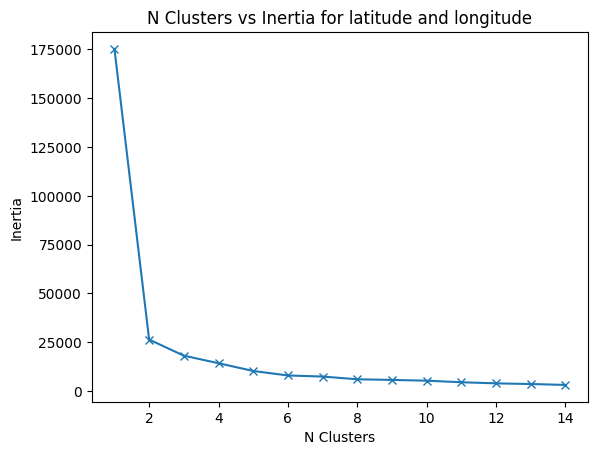

In [18]:
plot_kmeans_elbow(X, CLUSTERING_COLS)

So the optimal n_cluster value for latitude and longitude appears to be around 5.

In [19]:
NUM_CLUSTERS = 5

In [20]:
km = KMeans(NUM_CLUSTERS)
km.fit(X)

KMeans(n_clusters=5)

In [21]:
kmeans_silhouette_score = silhouette_score(X, km.fit_predict(X))
kmeans_silhouette_score

0.5632666489174138

### 3.2 Mean Shift Clustering

In [22]:
mean_shift_bandwidth = estimate_bandwidth(
    X,
    quantile=0.2,
    n_samples=5000
)

In [23]:
mean_shift_bandwidth

0.9690323038162227

In [24]:
ms = MeanShift(
    bandwidth=mean_shift_bandwidth,
    bin_seeding=True
)
ms.fit(X)

MeanShift(bandwidth=0.9690323038162227, bin_seeding=True)

In [25]:
labels = np.unique(ms.labels_)
ms_n_clusters = len(labels)
print(f"Mean Shift n_clusters: {ms_n_clusters}")

Mean Shift n_clusters: 6


In [26]:
mean_shift_silhouette_score = silhouette_score(X, ms.fit_predict(X))

In [27]:
mean_shift_silhouette_score

0.5435908885672336

Interestingly, Mean Shift has determined that there are 6 clusters rather than 5 as per the elbow method with KMeans. It will be interesting to see how the cluster plot differs.

### 3.3 DBSCAN

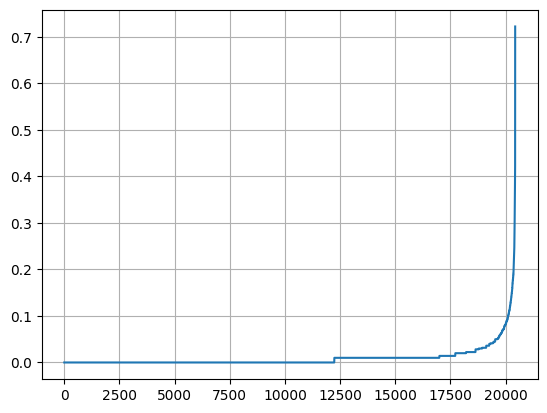

In [28]:
plot_eps_elbow_knn(X)

running eps: 0.2
running eps: 0.25
running eps: 0.3
running eps: 0.35


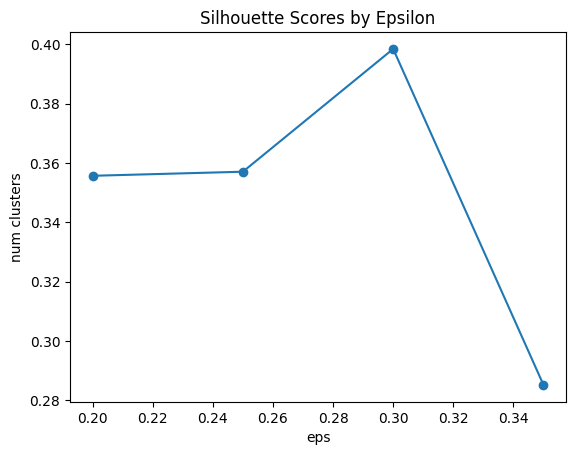

In [29]:
plot_silhouette_scores_by_eps(X, 0.2, 0.40, 0.05)

running min_sample value: 10
running min_sample value: 15
running min_sample value: 20
running min_sample value: 25
running min_sample value: 30
running min_sample value: 35
running min_sample value: 40
running min_sample value: 45
running min_sample value: 50
running min_sample value: 55


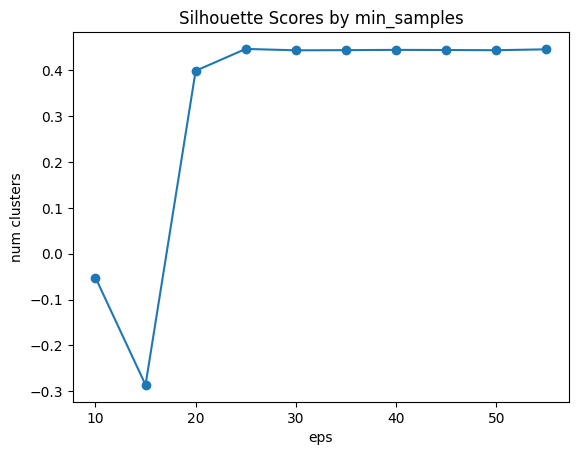

In [30]:
plot_silhouette_scores_by_min_samples(X, 10, 60, 5, 0.3)

In [31]:
dbscan_cityblocks = DBSCAN(
    eps=0.3,
    min_samples=25,
    n_jobs=-1
)

In [32]:
dbscan_cityblocks.fit(X)

DBSCAN(eps=0.3, min_samples=25, n_jobs=-1)

In [33]:
dbscan_n_clusters = len([l for l in np.unique(dbscan_cityblocks.labels_) if l >= 0])

In [34]:
dbscan_n_clusters

5

In [35]:
dbscan_sihouette_score = silhouette_score(X, dbscan_cityblocks.fit_predict(X))
dbscan_sihouette_score

0.4461304712958446

# 4. Model Evaluation

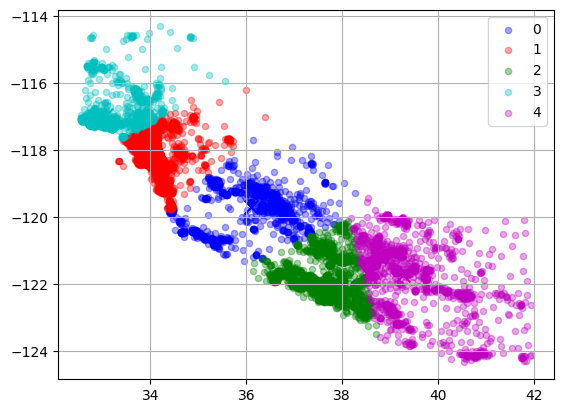

In [44]:
display_cluster(x=X, km=km, num_clusters=NUM_CLUSTERS)

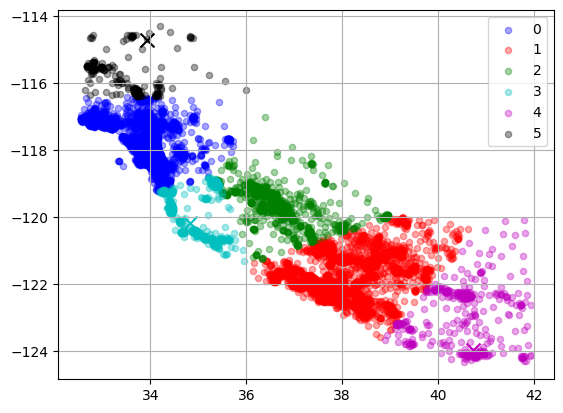

In [45]:
display_cluster(x=X, km=ms, num_clusters=ms_n_clusters)

In [39]:
dbscan_n_clusters

5

In [41]:
np.unique(dbscan_cityblocks.labels_)

array([-1,  0,  1,  2,  3,  4])

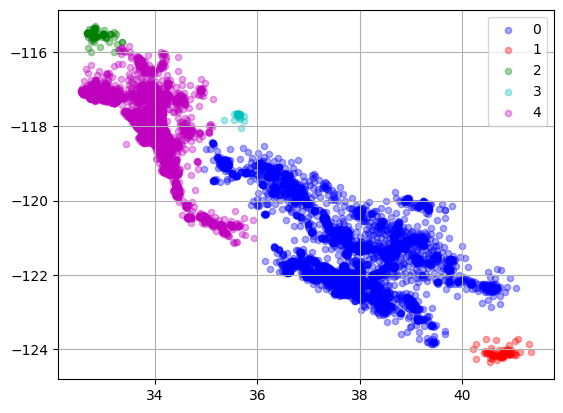

In [43]:
display_cluster(x=X, km=dbscan_cityblocks, num_clusters=dbscan_n_clusters)

There do appear to be some slight differences in the clustering between.

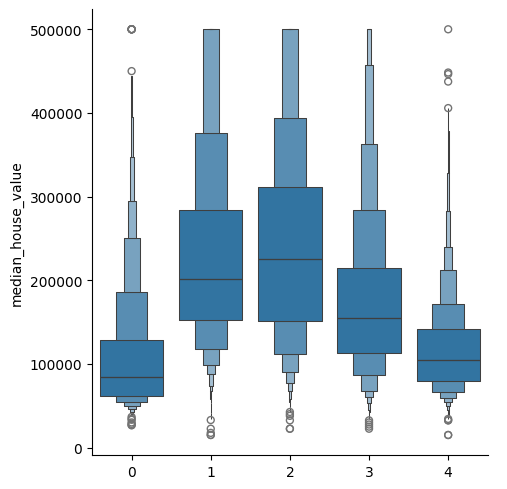

In [46]:
sns.catplot(X, x=km.labels_, y=housing_df['median_house_value'], kind='boxen')

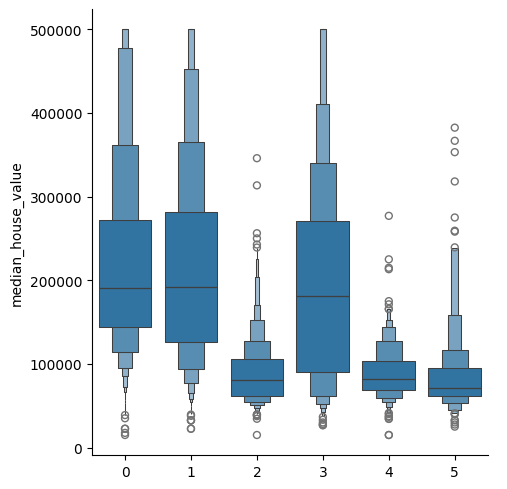

In [47]:
sns.catplot(X, x=ms.labels_, y=housing_df['median_house_value'], kind='boxen')

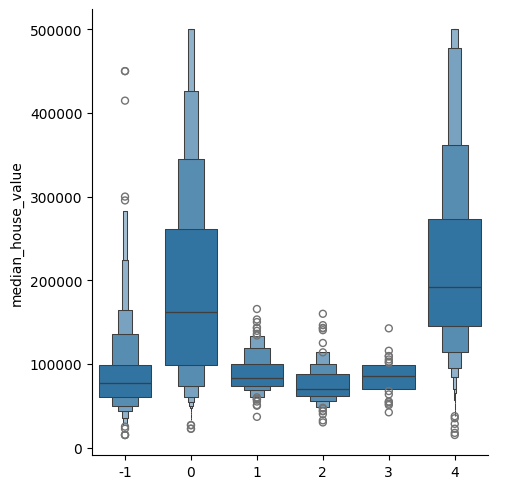

In [48]:
sns.catplot(X, x=dbscan_cityblocks.labels_, y=housing_df['median_house_value'], kind='boxen')

## 4. Conclusion

Overall, KMeans with 5 clusters gave the best silhouette score, and seemed to represent the dataset best. This was also supported by the catplot.